# Seeded Region Growing

Seeded region growing is a morphological image segmentation technique that expands regions from user-defined seed points based on similarity criteria. The method is particularly useful for segmenting images containing multiple class labels.

The algorithm follows that of [Adams and Bischof (1994)](https://ieeexplore.ieee.org/document/295913) and was translated from the implementation in [Fiji/ImageJ](https://ij-plugins.sourceforge.net/libraries/toolkit/javadoc/net/sf/ij_plugins/im3d/grow/SRG.html).

## Import packages

In [1]:
import dpm_tools as dpm
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_erosion as erode

[21:29:35] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=719100;file:///opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=240688;file:///opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

## Demonstration Image

Here, we will demonstrated the ``seeded_region_growing()`` function using a 3D $\mu$-CT image of an [oil blob trapped in a Ketton limestone](https://doi.org/10.17612/P7D95F).

Text(0.5, 0, 'Grayscale value')

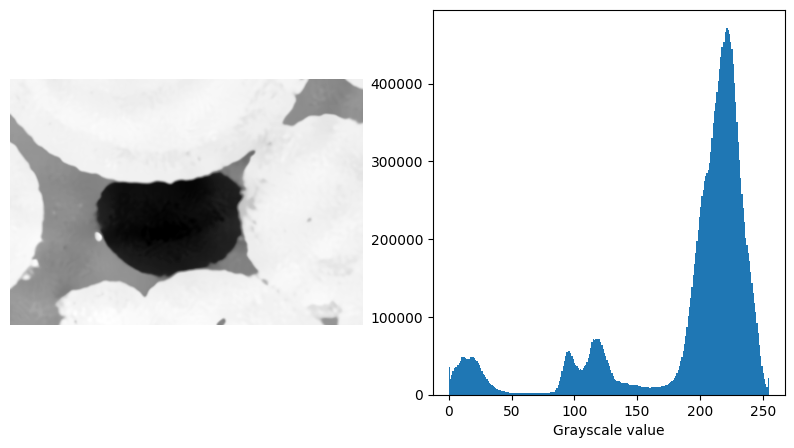

In [2]:
filtered_ketton = "../../_static/Ketton_rock_trapped_oil_Filtered_SSb.raw"

ketton_img = np.fromfile(filtered_ketton, dtype=np.uint16).reshape((225, 255, 365))

# Requantize ketton_img
ketton_img = (ketton_img - np.quantile(ketton_img, 0.001)) / (np.quantile(ketton_img, 0.999) - np.quantile(ketton_img, 0.001))
ketton_img[ketton_img < 0] = 0
ketton_img[ketton_img > 1] = 1

# Convert to uint8
ketton_img = (ketton_img * 255).astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(ketton_img[125], cmap="Greys_r")
ax1.axis(False)

ax2.hist(ketton_img.flatten(), bins=256)
ax2.set_xlabel("Grayscale value")

## Seeded Region Growing

Seeded Region Growing (SRG) is a region-based image segmentation method that begins with user-defined seed points. The algorithm iteratively examines neighboring voxels and adds them to the growing region if they meet a similarity criterion based on their grayscale values. 

### Seed selection

The process begins by selecting seeds. This could be done through manual labeling or by selecting conservative thresholds. Seeds should be labeled 1 - $n$, where $n$ is the number of desired segmentation classes. Label 0 is filled in during the segmentation process.

Text(0.5, 0, 'Grayscale value')

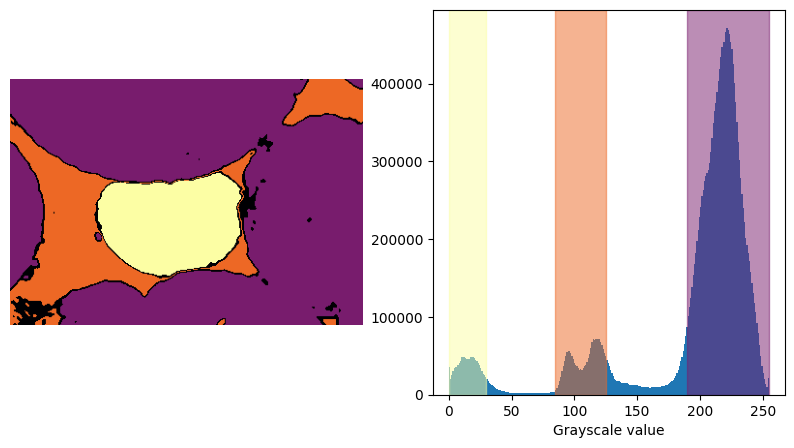

In [3]:
solid_label = (ketton_img >= 190).astype(np.uint8)
water_label = ((ketton_img >= 85) & (ketton_img <= 125)).astype(np.uint8) * 2
oil_label = (ketton_img <= 40).astype(np.uint8) * 3

seeds = solid_label + water_label + oil_label

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(seeds[125], cmap="inferno")
ax[0].axis(False)

ax[1].hist(ketton_img.flatten(), bins=256)
ax[1].axvspan(190, 255, color="#781c6d", alpha=0.5)
ax[1].axvspan(85, 125, color="#ed6825", alpha=0.5)
ax[1].axvspan(0, 30, color="#fcfea4", alpha=0.5)
ax[1].set_xlabel("Grayscale value")



### Seeded Region Growing

The SRG algorithm is conveniently wrapped in a Python function through DPM Tools. The function, ``dpm_tools.segmentation.seeded_region_growing()`` expects the grayscale image as an integer (8-, 16-, and 32-bit are supported) and an 8-bit image of the same size corresponding to the seed labels. 

The function supports both 2D and 3D images.

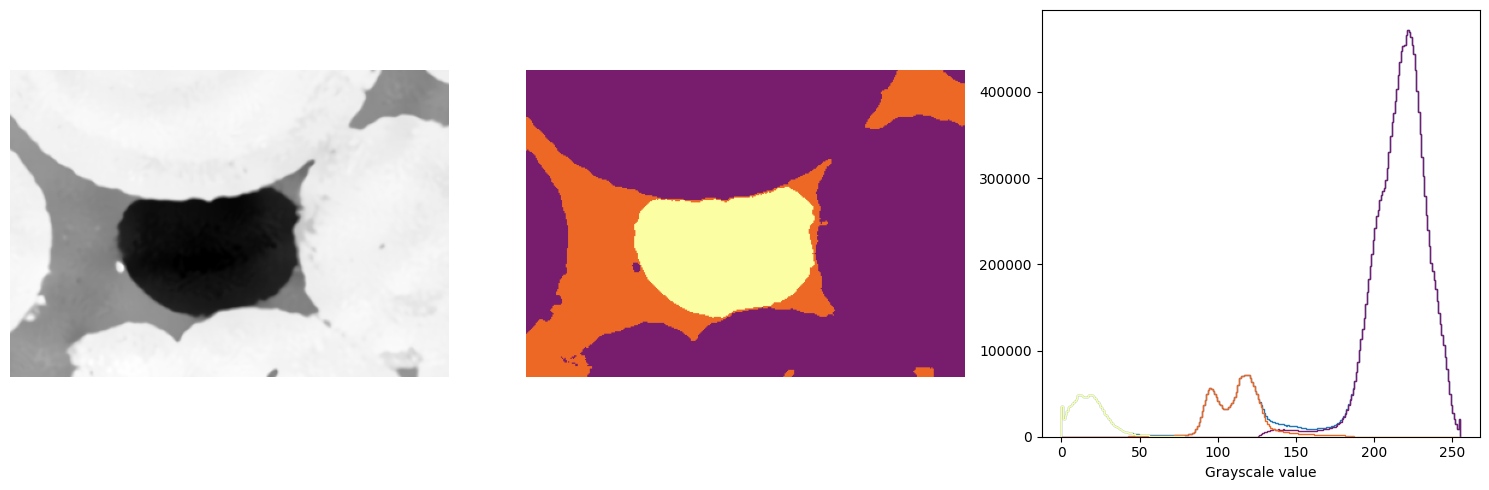

In [4]:
segmented = dpm.segmentation.seeded_region_growing(ketton_img, seeds)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ketton_img[125], cmap="Greys_r")
ax[0].axis(False)

ax[1].imshow(segmented[125], cmap="inferno", vmin=0, vmax=3)
ax[1].axis(False)

ax[2].hist(ketton_img.flatten(), bins=256, range=(0, 255), histtype="step")
ax[2].hist(ketton_img[segmented == 1].flatten(), bins=256, range=(0, 255), histtype="step", color="#781c6d")
ax[2].hist(ketton_img[segmented == 2].flatten(), bins=256, range=(0, 255), histtype="step", color="#ed6825")
ax[2].hist(ketton_img[segmented == 3].flatten(), bins=256, range=(0, 255), histtype="step", color="#fcfea4")
ax[2].set_xlabel("Grayscale value")
plt.tight_layout()


### Iterative Seeded Region Growing

Seeded region growing can result in small artifacts or misclassifications around phase boundaries. One remedy is to perform iterative seeded region growing, where phases are individually eroded and reused as seeds for another round of seeded region growing. This process helps the algorithm remove these artifacts and improve the segmentation. It is usually best to iterate until the histograms converge; however, we will only demonstrate one iteration here.

*Note*: Because SRG results depend on the order in which voxels are processed, it is usually a good idea to randomize the order by which the phases are eroded.

(np.float64(-0.5), np.float64(364.5), np.float64(254.5), np.float64(-0.5))

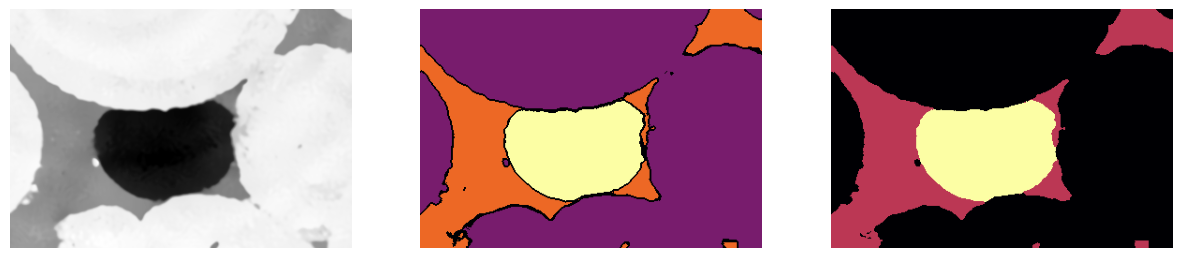

In [5]:
solid_label = erode(segmented == 1).astype(np.uint8)
water_label = erode(segmented == 2).astype(np.uint8) * 2
oil_label = erode(segmented == 3).astype(np.uint8) * 3

seeds_iter = solid_label + water_label + oil_label

segmented = dpm.segmentation.seeded_region_growing(ketton_img, seeds_iter)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ketton_img[125], cmap="Greys_r")
ax[0].axis(False)
ax[1].imshow(seeds_iter[125], cmap="inferno")
ax[1].axis(False)
ax[2].imshow(segmented[125], cmap="inferno")
ax[2].axis(False)
